### Deforestation Detection Using Sentinel-1 SAR

GEOG 313: Advanced Geospatial w/ Python Final Project

In [1]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [2]:
#aoi = [38.5899868, -4.9244565, 38.6700000, -4.8470000]

#aoi1 = [38.6579757, -4.9221954, 38.5899868, -4.8995308]

start = "2015-01-01"
end = "2024-12-31"

bands = ["VV", "VH"]

In [52]:
import rioxarray as rxr 

mask = rxr.open_rasterio("data/reforestation_area_300m_usambara.tif")

mask_img = leafmap.array_to_image(mask)


<open DatasetReader name='/vsimem/65c314fd-3b72-4f5f-b470-9991942cb7ca/65c314fd-3b72-4f5f-b470-9991942cb7ca.tif' mode='r'>

In [55]:
import leafmap

m = leafmap.Map(center=[-5.0467299, 38.7375924], zoom=17, height="800px", google_map="SATELLITE")
#m.add_raster(mask)
m

Map(center=[-5.0467299, 38.7375924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [32]:
aoi = (m.west, m.south, m.east, m.north)

In [16]:
import utils
search = utils.get_sar_pc(aoi, start, end)
stack = utils.items_to_xarray(search, aoi)
index = utils.calculate_index(stack, "RVI")
coarsened = utils.coarsen_image(index, scale = 3)
composite = utils.temporal_composite(coarsened)

In [17]:
deseasoned = utils.deseason(composite)

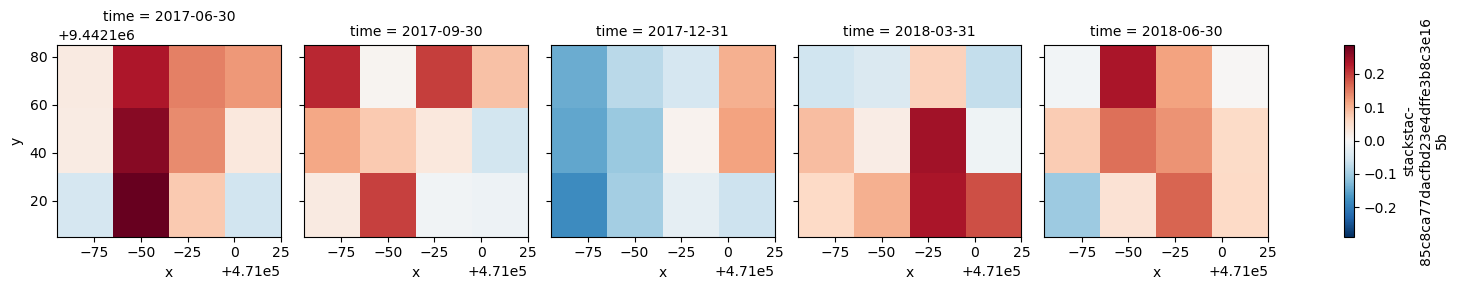

In [20]:

change = utils.img_change(deseasoned)
deseasoned.isel(time=[9, 10, 11, 12, 13]).plot.imshow(col="time", col_wrap=5)

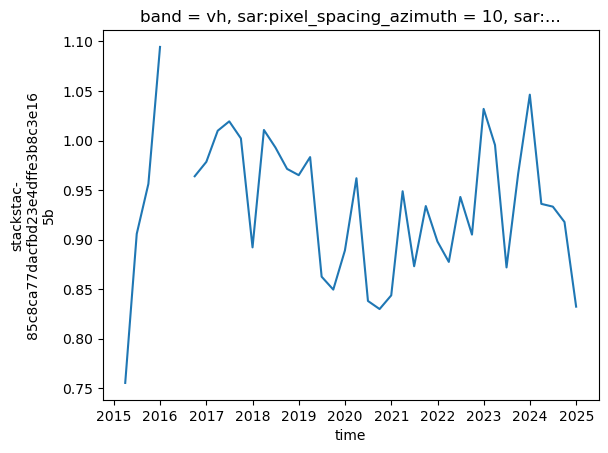

In [26]:
tsmean = composite.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)

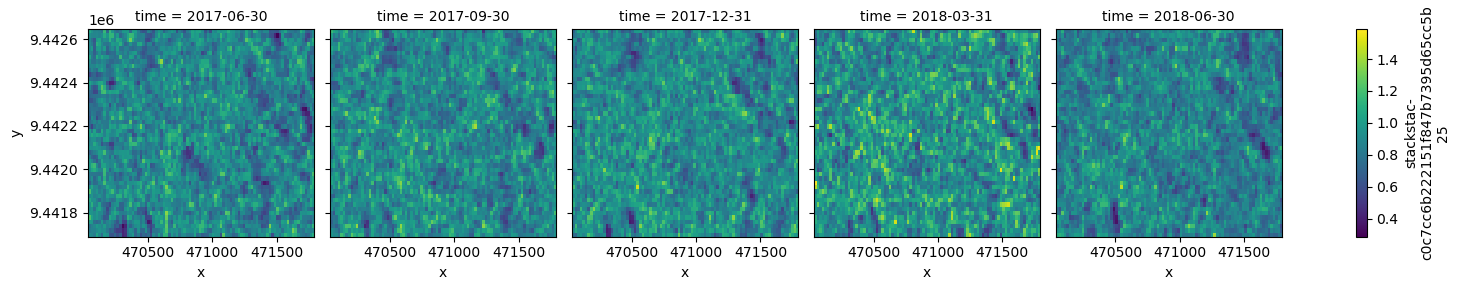

In [15]:
index = utils.calculate_index(composite, "RVI")
index.isel(time=[9, 10, 11, 12, 13]).plot.imshow(col="time", col_wrap=5)

stack.coords['year'] = ('time', stack.time.dt.year.data)

def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 1)
    return trend
import numpy as np 

rolling = index.rolling(time = 6, center = True)
rolling.construct("window_dim")

rolling.reduce(np.polyfit)

import xarray as xr
import rioxarray as rxr
import numpy as np
import stackstac
import os
import leafmap
import requests
from tqdm import tqdm
import pystac_client
import planetary_computer
from matplotlib import pyplot as plt
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=aoi,
    datetime='2015-01-01/2015-12-31'
)

items = search.get_all_items()
stack = stackstac.stack(items, 
                        assets=['SR_B4', 'SR_B5', 'QA_PIXEL'],
                        epsg=32737,
                        resolution=30,
                        bounds_latlon=aoi,
                       )

# mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
# bitmask = 0
# for field in mask_bitfields:
#     bitmask |= 1 << field

# bin(bitmask)

# qa = stack.sel(band="QA_PIXEL").astype("uint16")
# mask = qa & bitmask  # just look at those 4 bits

# cloud_free_stack = stack.where(mask == 0)

# sampled = cloud_free_stack.resample(time="1Q").median("time")

stack


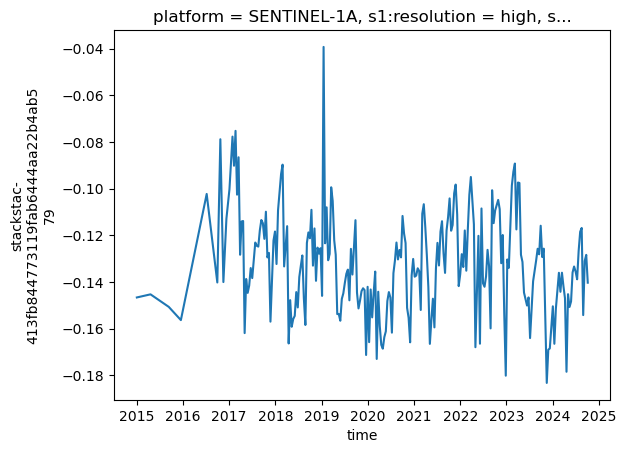

In [28]:
tsmean = index.mean(dim = ['y', 'x'], skipna = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
tsmean.plot(ax=ax)
#ax.set_ylim(0,1.2)


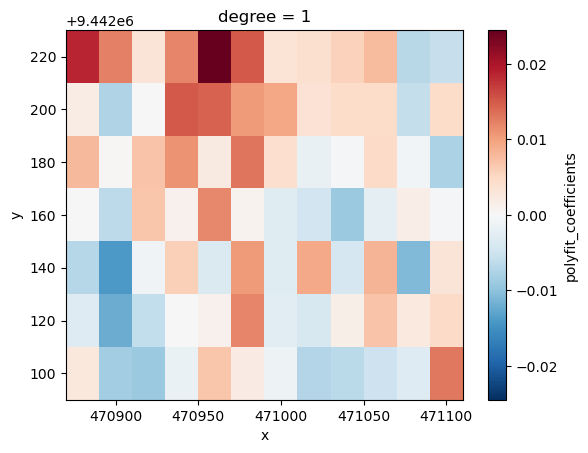

In [53]:
trends = utils.linear_trend(index)
linecoeff = trends.sel(degree = 1)

linecoeff.polyfit_coefficients.plot.imshow()